In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

In [10]:
# 1. Load and Visualize the Data
data = pd.read_excel("Gold_price_gbp.xlsx",index_col="Date", parse_dates=True)
prices = data['GBP'].values

In [11]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

In [12]:
# Define a function to create sequences
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length + 1])
    return np.array(sequences)

sequence_length = 10  # Choose your sequence length
sequences = create_sequences(prices_scaled, sequence_length)

In [13]:
# Split data into features and labels
X = sequences[:, :-1]
y = sequences[:, -1]

# Split the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [14]:

# Reshape data for CNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [15]:
# Build the hybrid model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(sequence_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=1)

Epoch 1/100
296/296 [==============================] - 9s 11ms/step - loss: 0.0011 - val_loss: 1.9743e-04
Epoch 2/100
296/296 [==============================] - 2s 7ms/step - loss: 4.5782e-05 - val_loss: 2.4048e-04
Epoch 3/100
296/296 [==============================] - 2s 7ms/step - loss: 4.4422e-05 - val_loss: 2.5517e-04
Epoch 4/100
296/296 [==============================] - 2s 7ms/step - loss: 4.7995e-05 - val_loss: 1.9253e-04
Epoch 5/100
296/296 [==============================] - 2s 7ms/step - loss: 5.1089e-05 - val_loss: 2.4022e-04
Epoch 6/100
296/296 [==============================] - 2s 7ms/step - loss: 4.7047e-05 - val_loss: 3.6856e-04
Epoch 7/100
296/296 [==============================] - 2s 7ms/step - loss: 5.4877e-05 - val_loss: 2.0000e-04
Epoch 8/100
296/296 [==============================] - 2s 7ms/step - loss: 4.8878e-05 - val_loss: 2.0083e-04
Epoch 9/100
296/296 [==============================] - 2s 7ms/step - loss: 4.7556e-05 - val_loss: 2.6171e-04


In [16]:
# Make predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

74/74 [==============================] - 1s 2ms/step


In [17]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
smape = np.mean(np.abs(y_test_actual - y_pred) / ((np.abs(y_test_actual) + np.abs(y_pred)) / 2)) * 100
mase = mae / np.mean(np.abs(np.diff(y_test_actual.flatten())))
r2 = r2_score(y_test_actual, y_pred)

# Print evaluation metrics
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'sMAPE: {smape}')
print(f'MASE: {mase}')
print(f'R2: {r2}')



MAE: 18.640511371335
MSE: 638.490410699081
RMSE: 25.268367788582648
MAPE: 1.5913535490715038
sMAPE: 1.5870232241018272
MASE: 2.3991237598184187
R2: 0.9918229053834389


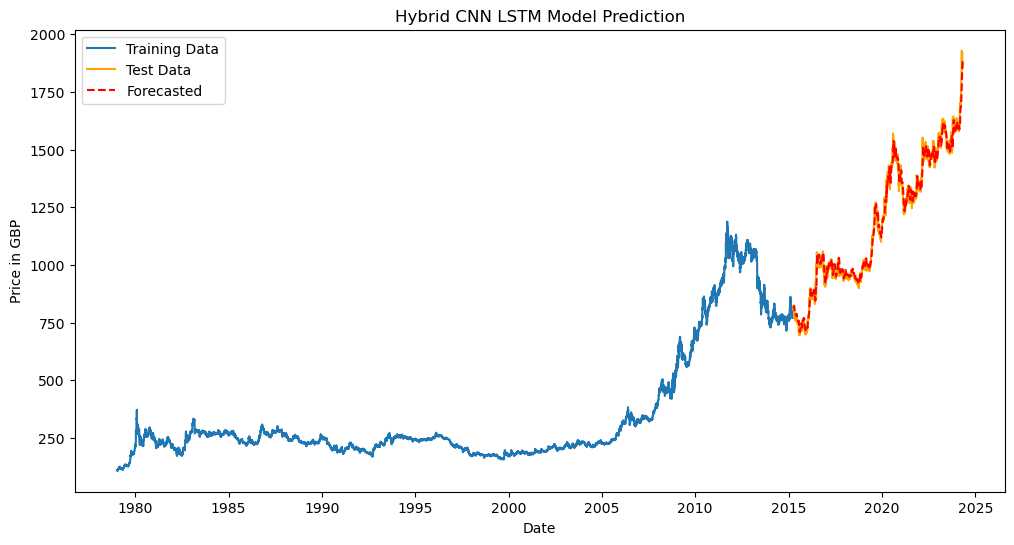

In [20]:

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(data.index[sequence_length:train_size + sequence_length], data.values[:train_size], label='Training Data')
plt.plot(data.index[-len(y_test):], y_test_actual, label='Test Data', color='orange')
plt.plot(data.index[-len(y_test):], y_pred, label='Forecasted',linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Price in GBP')
plt.title('Hybrid CNN LSTM Model Prediction')
plt.legend()
plt.show()